# Inference


In [1]:
# import libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm.auto import tqdm
import scripts.spotify_api as spotify_api

# Apply the default theme
sns.set_theme()


In [2]:
# input track ID
track_id = '0mflMxspEfB0VbI1kyLiAv'

## Fetching track audio features


In [3]:
# get tracks meta
track_meta = spotify_api.get_tracks_metadata(track_id)
track_meta

,id,name,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,is_local,popularity,preview_url,track_number,type,uri
0,0mflMxspEfB0VbI1kyLiAv,Stick Season,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,182346,False,{'isrc': 'USUM72212470'},{'spotify': 'https://open.spotify.com/track/0m...,False,90,None,2,track,spotify:track:0mflMxspEfB0VbI1kyLiAv


In [4]:
# hit spotify API
af = spotify_api.get_audio_features(track_id)
af

,index,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,time_signature
0,0,0.664,0.5,9,-6.935,1,0.0651,0.799,0,0.0966,0.801,117.896,0mflMxspEfB0VbI1kyLiAv,4


In [5]:
# merge metadata and audio features
df = pd.merge(track_meta, af, on='id')
df

,id,name,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0mflMxspEfB0VbI1kyLiAv,Stick Season,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,182346,False,{'isrc': 'USUM72212470'},{'spotify': 'https://open.spotify.com/track/0m...,...,9,-6.935,1,0.0651,0.799,0,0.0966,0.801,117.896,4


## Data Preprocessing


In [7]:
# Selecting the relevant audio features
features = ['duration_ms', 'popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
df[features]

,duration_ms,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,182346,90,0.664,0.5,9,-6.935,1,0.0651,0.799,0,0.0966,0.801,117.896,4


In [8]:
# extracting independent variables
X = df[features]

In [17]:
# Load the label encoder, scaler, and other preprocessing objects
import pickle
with open('models/preprocessing.pkl', 'rb') as f:
    preprocessing_objects = pickle.load(f)
    label_encoder = preprocessing_objects['label_encoder']
    scaler = preprocessing_objects['scaler']

label_encoder.classes_

array(['Electro chill', 'Hot Country', 'Summer Jazz', 'Trap Mojito',
       'hard Rock'], dtype=object)

In [15]:
# scale the features
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
X_scaled

,duration_ms,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,-0.429147,3.166909,0.887319,-0.348244,1.126628,0.345512,0.791714,-0.200611,1.057363,-0.836228,-0.677816,2.528505,-0.088111,0.260076


In [16]:
# dropping features from feature selection
# dropping loudness and acousticness
X_scaled.drop(columns=['loudness', 'acousticness', 'time_signature', 'key', 'mode'], inplace=True)
X_scaled

,duration_ms,popularity,danceability,energy,speechiness,instrumentalness,liveness,valence,tempo
0,-0.429147,3.166909,0.887319,-0.348244,-0.200611,-0.836228,-0.677816,2.528505,-0.088111


## inference


In [19]:
# building model class
import torch
from models.neural_net import NeuralNet

input_size = X_scaled.shape[1]
output_size = len(label_encoder.classes_)
hidden_sizes = [8, 8]

model = NeuralNet(input_size, hidden_sizes, output_size)
model

NeuralNet(
  (layers): ModuleList(
    (0): Linear(in_features=9, out_features=8, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)

In [21]:
# Load the trained weights 
model.load_state_dict(torch.load('models/neural_net_model.pth', weights_only=True))
# Set the model to evaluation mode
model.eval()

NeuralNet(
  (layers): ModuleList(
    (0): Linear(in_features=9, out_features=8, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)

In [23]:
# converting the input to tensor
X_tensor = torch.tensor(X_scaled.values, dtype=torch.float32)
X_tensor

tensor([[-0.4291,  3.1669,  0.8873, -0.3482, -0.2006, -0.8362, -0.6778,  2.5285,
         -0.0881]])

In [24]:
# inference
with torch.no_grad():
    y_logit = model(X_tensor)
    y_pred = torch.argmax(y_logit, dim=1)
    y_pred = label_encoder.inverse_transform(y_pred.numpy())

print('Predicted genre:', y_pred)

Probability distribution: [[7.9631738e-02 8.4489870e-01 4.7090743e-03 2.7584078e-04 7.0484646e-02]]
Predicted genre: ['Hot Country']


<Axes: >

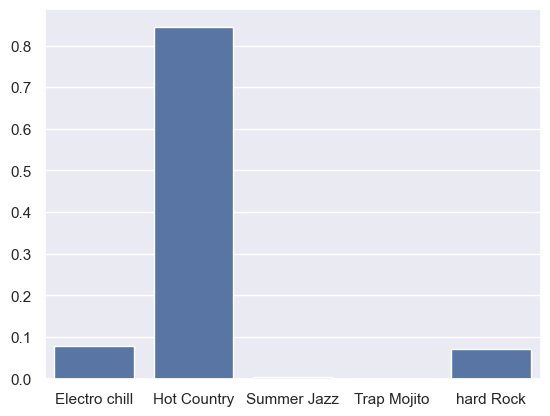

In [26]:
# plotting probabilities
probs = torch.nn.functional.softmax(y_logit, dim=1)
probs = probs.numpy()

# plot
sns.barplot(x=label_encoder.classes_, y=probs[0])
